# Project 1: Digit Classification with KNN and Naive Bayes

In this project, you'll implement your own image recognition system for classifying digits. Read through the code and the instructions carefully and add your own code where indicated. Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but <b> please prepare your own write-up (with your own code). </b>

If you're interested, check out these links related to digit recognition:

Yann Lecun's MNIST benchmarks: http://yann.lecun.com/exdb/mnist/

Stanford Streetview research and data: http://ufldl.stanford.edu/housenumbers/

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_mldata
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

Load the data. Notice that we are splitting the data into training, development, and test. We also have a small subset of the training data called mini_train_data and mini_train_labels that you should use in all the experiments below, unless otherwise noted.

In [2]:
# Load the digit data either from mldata.org, or once downloaded to data_home, from disk. The data is about 53MB so this cell
# should take a while the first time your run it.
mnist = fetch_mldata('MNIST original', data_home='~/datasets/mnist')
X, Y = mnist.data, mnist.target

# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print 'data shape: ', X.shape
print 'label shape:', Y.shape

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]

data shape:  (70000, 784)
label shape: (70000,)


(1) Create a 10x10 grid to visualize 10 examples of each digit. Python hints:

- plt.rc() for setting the colormap, for example to black and white
- plt.subplot() for creating subplots
- plt.imshow() for rendering a matrix
- np.array.reshape() for reshaping a 1D feature vector into a 2D matrix (for rendering)

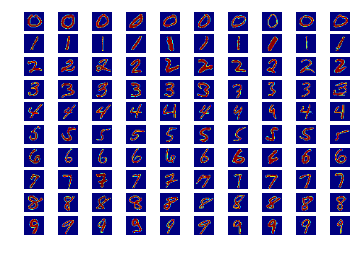

In [3]:
def P1(num_examples=10):

### STUDENT START ###
    count_list = [0]*10
    plotting_data = np.zeros((10,10,784),dtype=float)
    complete = False
    labels = train_labels.astype(int)
   
    #Going through the data and getting samples to plot
    for i in range(train_labels.size):
        if(not complete):
            value = labels[i]
            if(count_list[value]<num_examples):
                
                #Saving features for digits to plot.
                plotting_data[value][count_list[value]] = train_data[i]
                count_list[value] +=1
            
            #To check if we have all the required examples    
            complete = count_list[0] == num_examples and count_list[1] == num_examples and count_list[2] == num_examples and count_list[3] == num_examples and count_list[4] == num_examples and count_list[5] == num_examples and count_list[6] == num_examples and count_list[7] == num_examples and count_list[8] == num_examples and count_list[9] == num_examples
        else:
            break
    
    
    #Plotting examples
    fig = plt.figure()
    for row in range(10):
        for column in range(10):
            plt.subplot(10,10,(row*10+column)+1)
            plt.imshow(np.ndarray.reshape(plotting_data[row][column],[28,28]))
            plt.axis('off')
### STUDENT END ###

P1(10)

(2) Evaluate a K-Nearest-Neighbors model with k = [1,3,5,7,9] using the mini training set. Report accuracy on the dev set. For k=1, show precision, recall, and F1 for each label. Which is the most difficult digit?

- KNeighborsClassifier() for fitting and predicting
- classification_report() for producing precision, recall, F1 results

In [4]:
def P2(k_values):

### STUDENT START ###
    for k in k_values:
        #Creating Classifier
        knn_clf_p2 = KNeighborsClassifier(n_neighbors=k)
        knn_clf_p2.fit(mini_train_data,mini_train_labels)
        
        #Making Prediction
        predicted_labels = knn_clf_p2.predict(dev_data)
        wrong_prediction= (predicted_labels != dev_labels)
        
        #Reporting
        print 'K-Value:' + str(k), 'Accuracy:' + str(knn_clf_p2.score(dev_data,dev_labels))
        if k==1:
            print(classification_report(dev_labels,predicted_labels))
### STUDENT END ###

k_values = [1, 3, 5, 7, 9]
P2(k_values)


K-Value:1 Accuracy:0.888
             precision    recall  f1-score   support

        0.0       0.91      0.98      0.94        99
        1.0       0.89      1.00      0.94       105
        2.0       0.99      0.79      0.88       102
        3.0       0.77      0.87      0.82        86
        4.0       0.89      0.82      0.85       104
        5.0       0.93      0.84      0.88        91
        6.0       0.94      0.96      0.95        98
        7.0       0.89      0.92      0.90       113
        8.0       0.94      0.88      0.91        96
        9.0       0.78      0.82      0.80       106

avg / total       0.89      0.89      0.89      1000

K-Value:3 Accuracy:0.878
K-Value:5 Accuracy:0.869
K-Value:7 Accuracy:0.865
K-Value:9 Accuracy:0.863


ANSWER: 9 has the lowest F-1 score so it is the hardest to predict.

(3) Using k=1, report dev set accuracy for the training set sizes below. Also, measure the amount of time needed for prediction with each training size.

- time.time() gives a wall clock value you can use for timing operations

In [5]:
def P3(train_sizes, accuracies):

### STUDENT START ###
    k = 1
    for size in train_sizes:
        
        #Creating Training data subset 
        training_subset_data = train_data[0:size]
        training_subset_label = train_labels[0:size]
        
        #Creating Classifier
        knn_clf_p3 = KNeighborsClassifier(k)
        knn_clf_p3.fit(training_subset_data,training_subset_label)
        
        #Starting timer and Prediction
        start = time.time()
        predicted_labels = knn_clf_p3.predict(dev_data)
        
        #Done with Prediction and stopped timer.
        finish  = time.time()
        
        #Reporting
        right_prediction = (predicted_labels == dev_labels)
        accuracies.append(np.divide(np.sum(right_prediction,dtype=np.float32),predicted_labels.size))
        print 'Time Taken for prediction with ', size , ' samples is :' ,finish-start
    
    #Reporting Accuracies
    print 'Accuracies ', accuracies
### STUDENT END ###

train_sizes = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25000]
accuracies = []
P3(train_sizes, accuracies)

Time Taken for prediction with  100  samples is : 0.120275020599
Time Taken for prediction with  200  samples is : 0.218900918961
Time Taken for prediction with  400  samples is : 0.456754922867
Time Taken for prediction with  800  samples is : 0.883275985718
Time Taken for prediction with  1600  samples is : 1.80127096176
Time Taken for prediction with  3200  samples is : 3.53617691994
Time Taken for prediction with  6400  samples is : 7.22131800652
Time Taken for prediction with  12800  samples is : 14.2277219296
Time Taken for prediction with  25000  samples is : 27.9983489513
Accuracies  [0.71999999999999997, 0.78600000000000003, 0.84099999999999997, 0.88400000000000001, 0.90200000000000002, 0.92600000000000005, 0.93700000000000006, 0.95899999999999996, 0.96999999999999997]


(4) Fit a regression model that predicts accuracy from training size. What does it predict for n=60000? What's wrong with using regression here? Can you apply a transformation that makes the predictions more reasonable?

- Remember that the sklearn fit() functions take an input matrix X and output vector Y. So each input example in X is a vector, even if it contains only a single value.

In [6]:
def P4():

### STUDENT START ###
        #Creatign Classifier
        r_clf_p4 = LinearRegression()
        d= np.reshape(train_sizes,[9,1])
        
        # Fitting model
        regression_model_p4 = r_clf_p4.fit(d, accuracies)
        
        #Making Prediction + Reporting
        print 'Prediction for 60000 with linear model:'+str(regression_model_p4.predict(60000))
        
        # Performing  a 1/n transformation.
        train_transformed = np.zeros(len(train_sizes)) 
        for i in range(len(train_sizes)):
            train_transformed[i] = 1.0/train_sizes[i]
        
        #Regression with transformed data.
        r_clf_p4_1 = LinearRegression()
        d1= np.reshape(train_transformed,[9,1])
        
        # Fitting model
        regression_model_p4_1 = r_clf_p4_1.fit(d1, accuracies)
        
        #Making Prediction + Reporting
        print 'Prediction for 60000 with linear model:'+str(regression_model_p4_1.predict(1.0/60000))
        
### STUDENT END ###

P4()

Prediction for 60000 with linear model:[ 1.24307226]
Prediction for 60000 with linear model:[ 0.93312524]


ANSWER: The problem with using regression is that the model is trying to fit a linear model to this relationship. However, linear regression does not work very well with data that have a ceiling. Therefore, the predictions made by this model are nt very accurate. For eg the accuracy this model predicts for input size 60000 is greater than 1. That is not possible and does not make sense.
This probles is taken care of by  doing a 1/n transformation. This allows the precision values to be between 0 and 1. As the traininsg sizes go up the  the accuracy goes up as well.

Fit a 1-NN and output a confusion matrix for the dev data. Use the confusion matrix to identify the most confused pair of digits, and display a few example mistakes.

- confusion_matrix() produces a confusion matrix

Starting to train model
Completed training. Starting prediction
Computing Confusion Matrix
[[ 97   0   0   0   0   0   2   0   0   0]
 [  0 105   0   0   0   0   0   0   0   0]
 [  4   4  81   4   0   0   0   4   3   2]
 [  1   0   0  75   0   3   0   3   1   3]
 [  0   2   0   0  85   0   3   0   0  14]
 [  2   0   0   9   0  76   0   1   1   2]
 [  1   1   1   0   1   0  94   0   0   0]
 [  1   4   0   1   1   0   0 104   0   2]
 [  0   2   0   5   0   2   1   0  84   2]
 [  1   0   0   3   9   1   0   5   0  87]]
4.0 9.0
9.0 4.0


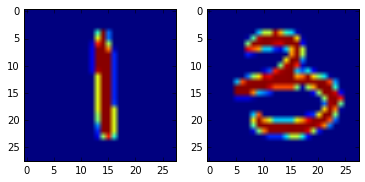

In [7]:
def P5():

### STUDENT START ###
    #Creating Classifier
    knn_clf_p5 = KNeighborsClassifier(1)
    
    #Fitting Data
    print ('Starting to train model')
    knn_clf_p5.fit(mini_train_data,mini_train_labels)
    
    #Predicting
    print ('Completed training. Starting prediction')
    predicted_labels=knn_clf_p5.predict(dev_data)
    
    #Reporting
    print ('Computing Confusion Matrix')
    print(confusion_matrix(dev_labels,predicted_labels))
    wrong_prediction= (predicted_labels != dev_labels)
    
    #Plotting Data
    fig = plt.figure(1)
    
    for i in range(len(wrong_prediction)):
        #Printing first confused value
        if(wrong_prediction[i] and int(dev_labels[i])== 4 and int(predicted_labels[i])== 9):
            print dev_labels[i], predicted_labels[i]
            plt.subplot(121)
            plt.imshow(np.ndarray.reshape(test_data[int(i)],[28,28]))
            break
    
    for j in range(len(wrong_prediction)):
        #Printing second confused value
        if(wrong_prediction[j] and int(dev_labels[j])== 9 and int(predicted_labels[j])== 4):
            print dev_labels[j], predicted_labels[j]
            plt.subplot(122)
            plt.imshow(np.ndarray.reshape(test_data[int(j)],[28,28]))
            break
## STUDENT END ###

P5()

9 and 4 are confused together the most.

(6) A common image processing technique is to smooth an image by blurring. The idea is that the value of a particular pixel is estimated as the weighted combination of the original value and the values around it. Typically, the blurring is Gaussian -- that is, the weight of a pixel's influence is determined by a Gaussian function over the distance to the relevant pixel.

Implement a simplified Gaussian blur by just using the 8 neighboring pixels: the smoothed value of a pixel is a weighted combination of the original value and the 8 neighboring values. Try applying your blur filter in 3 ways:
- preprocess the training data but not the dev data
- preprocess the dev data but not the training data
- preprocess both training and dev data

Note that there are Guassian blur filters available, for example in scipy.ndimage.filters. You're welcome to experiment with those, but you are likely to get the best results with the simplified version I described above.

In [8]:
def P6():
    
### STUDENT START ###
        print 'Blurring Data'
        training_data_blur = process_data(train_data)
        dev_data_blur  = process_data(dev_data)
        
        print 'Fitting First Scenario - Blurred Training Data'
        knn_clf_p6_1 = KNeighborsClassifier(1)
        knn_clf_p6_1.fit(training_data_blur, train_labels)
        knn_clf_p6_1_predicted_labels = knn_clf_p6_1.predict(dev_data)
        print(classification_report(knn_clf_p6_1_predicted_labels,dev_labels))
        
        
        print 'Fitting Second Scenario - Blurred Dev Data'
        knn_clf_p6_2 = KNeighborsClassifier(1)
        knn_clf_p6_2.fit(train_data, train_labels)
        knn_clf_p6_2_predicted_labels = knn_clf_p6_2.predict(dev_data_blur)
        print(classification_report(knn_clf_p6_2_predicted_labels,dev_labels))
        
        
        print 'Fitting Third Scenario - Blurred Training and Dev Data'
        knn_clf_p6_3 = KNeighborsClassifier(1)
        knn_clf_p6_3.fit(training_data_blur, train_labels)
        knn_clf_p6_3_predicted_labels = knn_clf_p6_3.predict(dev_data_blur)
        print(classification_report(knn_clf_p6_3_predicted_labels,dev_labels))

#Helper method
def process_data(raw_data):
    formatted_data = np.empty_like(raw_data)
    for i in range(len(raw_data)):
        formatted_data[i]=smooth(raw_data[i])
    return formatted_data

#Smoothening data
def smooth(data):
    data_formatted = []
    for i in range(28):
        for j in range(28):
            if i == 0:
                if j == 0:
                    data_formatted.append(np.divide(np.sum([get_value(i,j,data),get_value(i+1,j,data),get_value(i+1,j+1,data),get_value(i,j+1,data)]),4))
                elif j == 27:
                    data_formatted.append(np.divide(np.sum([get_value(i,j,data),get_value(i,j-1,data),get_value(i+1,j-1,data),get_value(i+1,j,data)]),4))
                else:
                    data_formatted.append(np.divide(np.sum([get_value(i,j,data),get_value(i,j-1,data),get_value(i+1,j-1,data),get_value(i+1,j,data),get_value(i+1,j+1,data),get_value(i,j+1,data)]),6))
            elif i == 27:
                if j == 0:
                    data_formatted.append(np.divide(np.sum([get_value(i,j,data),get_value(i-1,j,data),get_value(i-1,j-1,data),get_value(i,j+1,data)]),4))
                elif j == 27:
                    data_formatted.append(np.divide(np.sum([get_value(i,j,data),get_value(i-1,j,data),get_value(i-1,j-1,data),get_value(i-1,j,data)]),4))
                else:
                    data_formatted.append(np.divide(np.sum([get_value(i,j,data),get_value(i,j-1,data),get_value(i-1,j-1,data),get_value(i-1,j,data),get_value(i-1,j+1,data),get_value(i,j+1,data)]),6))               
            else:
                if j == 0:
                    data_formatted.append(np.divide(np.sum([get_value(i,j,data),get_value(i+1,j,data),get_value(i+1,j+1,data),get_value(i,j+1,data),get_value(i-1,j+1,data),get_value(i-1,j,data)]),6))
                elif j == 27:
                    data_formatted.append(np.divide(np.sum([get_value(i,j,data),get_value(i,j-1,data),get_value(i+1,j-1,data),get_value(i+1,j,data),get_value(i-1,j,data),get_value(i-1,j-1,data)]),6))
                else:
                    data_formatted.append(np.divide(np.sum([get_value(i,j,data),get_value(i,j-1,data),get_value(i+1,j-1,data),get_value(i+1,j,data),get_value(i+1,j+1,data),get_value(i,j+1,data),get_value(i-1,j+1,data),get_value(i-1,j,data),get_value(i-1,j-1,data)]),9))
    return data_formatted


#This method computes what position in a vector corresponds to a 2d matrix
def get_value(row,column,data):
    max_row, max_column = 28, 28
    return data[((row % max_row) + (column % max_column)) + (row * (max_column-1))]
        
### STUDENT END ###

P6()

Blurring Data
Fitting First Scenario - Blurred Training Data
             precision    recall  f1-score   support

        0.0       1.00      0.98      0.99       101
        1.0       1.00      0.99      1.00       106
        2.0       0.96      0.99      0.98        99
        3.0       0.94      0.95      0.95        85
        4.0       0.99      0.99      0.99       104
        5.0       0.98      0.99      0.98        90
        6.0       0.98      1.00      0.99        96
        7.0       1.00      0.98      0.99       115
        8.0       0.96      0.99      0.97        93
        9.0       1.00      0.95      0.98       111

avg / total       0.98      0.98      0.98      1000

Fitting Second Scenario - Blurred Dev Data
             precision    recall  f1-score   support

        0.0       1.00      0.97      0.99       102
        1.0       1.00      0.96      0.98       109
        2.0       0.92      0.99      0.95        95
        3.0       0.95      0.92      0.94  

ANSWER: The training  data seems to make all the difference. When the training data is blurred, the f-1 score is high. It allows for a more generalized fit. Thereby, making better predictions. 

(7) Fit a Naive Bayes classifier and report accuracy on the dev data. Remember that Naive Bayes estimates P(feature|label). While sklearn can handle real-valued features, let's start by mapping the pixel values to either 0 or 1. You can do this as a preprocessing step, or with the binarize argument. With binary-valued features, you can use BernoulliNB. Next try mapping the pixel values to 0, 1, or 2, representing white, grey, or black. This mapping requires MultinomialNB. Does the multi-class version improve the results? Why or why not?

In [14]:
def P7():

### STUDENT START ###
    
    # Binarizing Data
    print "Converting Data to Binomial"
    b_train_data_p7 = binarize_data(train_data,[0.5])
    b_test_data_p7 = binarize_data(test_data,[0.5])
    
    #Bernoulli Classifier
    bernoulli_classifier = BernoulliNB(1)
    bernoulli_model = bernoulli_classifier.fit(b_train_data_p7,train_labels)
    b_prediction = bernoulli_model.score(b_test_data_p7,test_labels )
    print 'Prediction with Binomial', b_prediction
    
    #Converting to Multinomial Variable
    print "Converting Data to Multinomial"
    m_traning_data_p7 = multinomialize_data(train_data)
    m_dev_data_p7 = multinomialize_data(dev_data)
    
    #Multinomial Prediction
    multinomial_classifier = MultinomialNB(1)
    multinomial_data_model = multinomial_classifier.fit(m_traning_data_p7,train_labels)
    m_prediction = multinomial_data_model.score(m_dev_data_p7,dev_labels)
    print 'Prediction with Multinomial',m_prediction

    
#Helper Method to binarize the data 
def binarize_data(data, thresholds):
    # Initialize a new feature array with the same shape as the original data.
    binarized_data = np.zeros(data.shape)
    
    #Apply a threshold  to each feature.
    for feature_bd in range(data.shape[1]):
        binarized_data[:,feature_bd] = data[:,feature_bd] > thresholds[0]
    return binarized_data

#Helper Method to Multinomialize data. The threshhold used are: 0.01 and 0.9
def multinomialize_data(data):
    mult_data = np.zeros(data.shape)
    for point in range(len(data)):
        mult_point = np.zeros(data[point].shape)
        data_point = data[point]
        #if(point == 0):
            #print data_point
        for feature in range(data_point.size):
            if(data_point[feature] >= 0.0 and data_point[feature] <= 0.01):
                mult_point[feature] = 0
            elif(data_point[feature] > 0.01  and data_point[feature]<=0.9):
                mult_point[feature] = 1
            else:
                mult_point[feature] = 2
        mult_data[point] = mult_point
    return mult_data


### STUDENT END ###

P7()

Converting Data to Binomial
Prediction with Binomial 0.838222222222
Converting Data to Multinomial
Prediction with Multinomial 0.823


(8) Use GridSearchCV to perform a search over values of alpha (the Laplace smoothing parameter) in a Bernoulli NB model. What is the best value for alpha? What is the accuracy when alpha=0? Is this what you'd expect?

- Note that GridSearchCV partitions the training data so the results will be a bit different than if you used the dev data for evaluation.

In [10]:
def P8(alphas):

### STUDENT START ###

   # Binarizing Data
    print "Converting Data to Binomial"
    b_train_data_p8 = binarize_data(train_data,[0.5])
    b_test_data_p8 = binarize_data(test_data,[0.5])
    
    #Fitting the model
    b_clf_p8 = BernoulliNB()
    gsv = GridSearchCV(b_clf_p8,alphas)
    gsv_model = gsv.fit(b_train_data_p8,train_labels)
    
    #Reporting
    print gsv.best_estimator_
    
    #Manually checking a few alpha accuracies
    print 'Alpha: 0.0001 Accuracy: ', BernoulliNB(0.0001).fit(b_train_data_p8,train_labels).score(b_test_data_p8,test_labels)
    print 'Alpha: 0.0 Accuracy: ',BernoulliNB(0).fit(b_train_data_p8,train_labels).score(b_test_data_p8,test_labels)
    return gsv
### STUDENT END ###

alphas = {'alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
nb = P8(alphas)

Converting Data to Binomial


/home/divyang/anaconda2/lib/python2.7/site-packages/sklearn/naive_bayes.py:766: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc)


BernoulliNB(alpha=0.0001, binarize=0.0, class_prior=None, fit_prior=True)
Alpha: 0.0001 Accuracy:  0.839444444444
Alpha: 0.0 Accuracy:  0.0965555555556


In [15]:
print nb.best_params_

{'alpha': 0.0001}


ANSWER:The best value for alpha is 0.0001. The accuracy for alpha=0 is 0.0965555555556. This is what we expect for alpha=0 because the this involves no smoothing as a result some probabilities for data that wasnt in the training set will be reported to be zero.

(9) Try training a model using GuassianNB, which is intended for real-valued features, and evaluate on the dev data. You'll notice that it doesn't work so well. Try to diagnose the problem. You should be able to find a simple fix that returns the accuracy to around the same rate as BernoulliNB. Explain your solution.

Hint: examine the parameters estimated by the fit() method, theta\_ and sigma\_.

In [11]:
def P9():

### STUDENT END ###
    g_clf = GaussianNB()
    g_model = g_clf.fit(train_data,train_labels)
    print g_clf.class_prior_[1]
    g_predicted = g_model.score(test_data,test_labels)
    print g_predicted

### STUDENT END ###

gnb = P9()

0.11215
0.562555555556


ANSWER: The mean is 0 as there is no alpha associated with the classifier. That needs to be fixed. For the data, adding some whiste noise would help.

(10) Because Naive Bayes is a generative model, we can use the trained model to generate digits. Train a BernoulliNB model and then generate a 10x20 grid with 20 examples of each digit. Because you're using a Bernoulli model, each pixel output will be either 0 or 1. How do the generated digits compare to the training digits?

- You can use np.random.rand() to generate random numbers from a uniform distribution
- The estimated probability of each pixel is stored in feature\_log\_prob\_. You'll need to use np.exp() to convert a log probability back to a probability.

In [12]:
def P10(num_examples):

### STUDENT START ###
    print "Converting Data to Binomial"
    b_train_data_p10 = binarize_data(train_data,[0.5])
    b_test_data_p10 = binarize_data(test_data,[0.5])
    
    b_clf = BernoulliNB(1)
    b_model = b_clf.fit(b_train_data_p10,train_labels)
    final_gen_vector = np.zeros((10,20,784),dtype=float)
    
    #Going through number of examples of each digit
    #Second Index is the Number of example
    for second_index in range(num_examples):
        rand_vector = np.random.rand(10,784)
        #Comparing the random generated vector to the model probabilities and generating a boolean vector.
        gen_boolean_vector = rand_vector < np.exp(b_model.feature_log_prob_)
        
        #Going through the examples and pixels to binarize the data.
        #First Index is the digit in question
        for first_index in range(10):
            #third index is the pixel in question
            for third_index in range (784):
                if(gen_boolean_vector[first_index][third_index]):
                    final_gen_vector[first_index][second_index][third_index]=1.0
    
    #Examined the generated data 
    for index in range(10):
        print 'Digit: ', index, b_model.predict(final_gen_vector[index])
        
        
### STUDENT END ###

P10(20)

Converting Data to Binomial
Digit:  0 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]
Digit:  1 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.]
Digit:  2 [ 2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.]
Digit:  3 [ 3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.
  3.  3.]
Digit:  4 [ 4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.
  4.  4.]
Digit:  5 [ 5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.
  5.  5.]
Digit:  6 [ 6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.
  6.  6.]
Digit:  7 [ 7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.
  7.  7.]
Digit:  8 [ 8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.
  8.  8.]
Digit:  9 [ 9.  9.  9.  9.  9.  9.  9.  9.  9.  9.  9.  9.  9.  9.  9.  9.  9.  9.
  9.  9.]


ANSWER: The digits generated have a 100% accurance as compared to the training data.

(11) Remember that a strongly calibrated classifier is rougly 90% accurate when the posterior probability of the predicted class is 0.9. A weakly calibrated classifier is more accurate when the posterior is 90% than when it is 80%. A poorly calibrated classifier has no positive correlation between posterior and accuracy.

Train a BernoulliNB model with a reasonable alpha value. For each posterior bucket (think of a bin in a histogram), you want to estimate the classifier's accuracy. So for each prediction, find the bucket the maximum posterior belongs to and update the "correct" and "total" counters.

How would you characterize the calibration for the Naive Bayes model?

In [13]:
def P11(buckets, correct, total):
    
### STUDENT START ###
    
    #Converting Data
    print "Converting Data to Binomial"
    b11_train_data = binarize_data(train_data,[0.5])
    b11_test_data = binarize_data(test_data,[0.5])
    
    #Training model, using best alpha from GridSearchCV
    b11_clf = BernoulliNB(0.0001)
    
    b11_model = b11_clf.fit(b11_train_data,train_labels)
    
    #Getting posteriors
    p_p = b11_model.predict_proba(b11_test_data)
    
    print p_p.shape
    #Going through posteriors and gathering statistics
    for row in range(9000):
        for column in range(10):
            index_updated = updateCount(total,p_p[row][column])
            if(np.argmax(p_p[row]) == test_labels[row]):
                correct[index_updated] +=1.0

#Helper method to update count. Found np.digitize but had already written this method.            
def updateCount(dest,data):
    if(data<=0.5):
        dest[0] += 1.0
        return 0
    elif(data<=0.9):
        dest[1]+=1.0
        return 1
    elif(data<=0.999):
        dest[2]+=1.0
        return 2
    elif(data<=0.99999):
        dest[3]+=1.0
        return 3
    elif(data<=0.9999999):
        dest[4]+=1.0
        return 4
    elif(data<=0.999999999):
        dest[5]+=1.0
        return 5
    elif(data<=0.99999999999):
        dest[6]+=1.0
        return 6
    elif(data<=0.9999999999999):
        dest[7]+=1.0
        return 7
    elif(data<= 1.0):
        dest[8]+=1.0
        return 8
### STUDENT END ###

buckets = [0.5, 0.9, 0.999, 0.99999, 0.9999999, 0.999999999, 0.99999999999, 0.9999999999999, 1.0]
correct = [0 for i in buckets]
total = [0 for i in buckets]
P11(buckets, correct, total)

for i in range(len(buckets)):
    accuracy = 0.0
    if (total[i] > 0): accuracy = correct[i] / total[i]
    print 'p(pred) <= %.13f    total = %3d   correct = %3d  accuracy = %.3f' %(buckets[i], total[i],correct[i], accuracy)

Converting Data to Binomial
(9000, 10)
p(pred) <= 0.5000000000000    total = 81004   correct = 67997  accuracy = 0.839
p(pred) <= 0.9000000000000    total = 373   correct = 149  accuracy = 0.399
p(pred) <= 0.9990000000000    total = 813   correct = 401  accuracy = 0.493
p(pred) <= 0.9999900000000    total = 699   correct = 450  accuracy = 0.644
p(pred) <= 0.9999999000000    total = 710   correct = 508  accuracy = 0.715
p(pred) <= 0.9999999990000    total = 643   correct = 504  accuracy = 0.784
p(pred) <= 0.9999999999900    total = 641   correct = 565  accuracy = 0.881
p(pred) <= 0.9999999999999    total = 558   correct = 521  accuracy = 0.934
p(pred) <= 1.0000000000000    total = 4559   correct = 4455  accuracy = 0.977


ANSWER: It is strongly calibrated.

(12) EXTRA CREDIT

Try designing extra features to see if you can improve the performance of Naive Bayes on the dev set. Here are a few ideas to get you started:
- Try summing the pixel values in each row and each column.
- Try counting the number of enclosed regions; 8 usually has 2 enclosed regions, 9 usually has 1, and 7 usually has 0.

Make sure you comment your code well!

In [ ]:
#def P12():

### STUDENT START ###


### STUDENT END ###

#P12()